# Sale Price Prediction Notebook

## Objectives

## Inputs

## Outputs

## Additional Comments

---

## Change working directory

We need to change the working directory from its current folder to its parent folder

* We access the current directory with os.getcwd()

In [3]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/ames-heritage-housing/jupyter_notebooks'

We want to make the parent of the current directory the new current directory

* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [4]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new directory

In [5]:
current_dir = os.getcwd()
current_dir

'/workspace/ames-heritage-housing'

## Load Data

In [6]:
import numpy as py
import pandas as pd

df = pd.read_csv(f"outputs/datasets/collection/house_prices_records.csv")
df.head()

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,...,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854.0,3.0,No,706,GLQ,150,0.0,548,RFn,...,65.0,196.0,61,5,7,856,0.0,2003,2003,208500
1,1262,0.0,3.0,Gd,978,ALQ,284,NaN,460,RFn,...,80.0,0.0,0,8,6,1262,NaN,1976,1976,181500
2,920,866.0,3.0,Mn,486,GLQ,434,0.0,608,RFn,...,68.0,162.0,42,5,7,920,NaN,2001,2002,223500
3,961,NaN,NaN,No,216,ALQ,540,NaN,642,Unf,...,60.0,0.0,35,5,7,756,NaN,1915,1970,140000
4,1145,NaN,4.0,Av,655,GLQ,490,0.0,836,RFn,...,84.0,350.0,84,5,8,1145,NaN,2000,2000,250000


## ML Pipeline: Regression

### Create the ML Pipeline

In [7]:
from sklearn.pipeline import Pipeline

# Data Cleaning
from feature_engine.selection import DropFeatures
from feature_engine.imputation import CategoricalImputer
from feature_engine.imputation import ArbitraryNumberImputer
from feature_engine.imputation import MeanMedianImputer

# Feature Engineering
from feature_engine import transformation as vt
from feature_engine.outliers import Winsorizer
from feature_engine.encoding import OrdinalEncoder
from feature_engine.selection import SmartCorrelatedSelection

# Feature Scaling
from sklearn.preprocessing import StandardScaler

# Feature Selection
from sklearn.feature_selection import SelectFromModel

# ML Algorithms
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

# Dropped features from smart correlation '1stFlrSF', 'GarageYrBlt', 'GrLivArea', 'YearRemodArea'

def PipelineOptimization(model):
    pipeline_base = Pipeline([
        # Cleaning Pipeline
        ("DropFeatures", DropFeatures(features_to_drop=['EnclosedPorch', 'WoodDeckSF'])),
        ("CategoricalImputer", CategoricalImputer(imputation_method='missing', fill_value='Unf', variables=['BsmtFinType1', 'GarageFinish'])),
        ("ArbitraryNumberImputer", ArbitraryNumberImputer(arbitrary_number=0, variables=['2ndFlrSF', 'MasVnrArea'])),
        ("MeanMedianImputer", MeanMedianImputer(imputation_method='median', variables=['BedroomAbvGr', 'GarageYrBlt', 'LotFrontage'])),
        # Feature Engineering
        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary', variables=['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual'])),
        ("NumericLogTransform", vt.LogTransformer(variables=['1stFlrSF', 'GrLivArea'], base='e')),
        ("NumericYeoJohnsonTransform", vt.YeoJohnsonTransformer(variables=['BsmtUnfSF', 'TotalBsmtSF', 'GarageArea'])),
        ("NumericPowerTransform", vt.PowerTransformer(variables=['LotArea'])),
        ("Winsorizer", Winsorizer(capping_method='iqr', tail='both', fold=1.5, variables=['GrLivArea'])),
        ("SmartCorrelationSelection", SmartCorrelatedSelection(variables=None, method="spearman", threshold=0.6, selection_method="variance")),
        # Feature Scaling
        ("scaler", StandardScaler()),
        # Feature Selection
        ("feat_selection", SelectFromModel(model)),
        # ML Algorithms
        ("model", model),
    ])

    return pipeline_base


/workspace/.pyenv_mirror/user/3.8.18/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


Next we create a custom class for hyperparameter optimisation:

In [8]:
from sklearn.model_selection import GridSearchCV


class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")
            model = PipelineOptimization(self.models[key])

            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring)
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score',
                   'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns], self.grid_searches

## Split Train and Test Sets

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['SalePrice'], axis=1),
    df['SalePrice'],
    test_size=0.2,
    random_state=0,
)

print("* Train set:", X_train.shape, y_train.shape,
     "\n* Test set:", X_test.shape, y_test.shape)

* Train set: (1168, 23) (1168,) 
* Test set: (292, 23) (292,)


## Grid Search CV - Sklearn

We will use deault hyperparameters first to find most suitable algorithm:

In [10]:
models_search = {
    'LinearRegression': LinearRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
}

params_search = {
    'LinearRegression': {},
    "DecisionTreeRegressor": {},
    "RandomForestRegressor": {},
    "ExtraTreesRegressor": {},
    "AdaBoostRegressor": {},
    "GradientBoostingRegressor": {},
    "XGBRegressor": {},
}

We will conduct the search using these default hyperparameters:

In [11]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pyenv_mirror/user/3.8.18/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pyenv_mirror/user/3.8.18/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pyenv_mirror/user/3.8.18/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pyenv_mirror/user/3.8.18/lib/python3.8/site-packages/feature_engine/se


Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pyenv_mirror/user/3.8.18/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pyenv_mirror/user/3.8.18/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pyenv_mirror/user/3.8.18/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pyenv_mirror/user/3.8.18/lib/python3.8/site-packages/feature_engine/se


Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pyenv_mirror/user/3.8.18/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pyenv_mirror/user/3.8.18/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pyenv_mirror/user/3.8.18/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pyenv_mirror/user/3.8.18/lib/python3.8/site-packages/feature_engine/se


Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pyenv_mirror/user/3.8.18/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pyenv_mirror/user/3.8.18/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pyenv_mirror/user/3.8.18/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pyenv_mirror/user/3.8.18/lib/python3.8/site-packages/feature_engine/se


Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pyenv_mirror/user/3.8.18/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pyenv_mirror/user/3.8.18/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pyenv_mirror/user/3.8.18/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pyenv_mirror/user/3.8.18/lib/python3.8/site-packages/feature_engine/se


Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pyenv_mirror/user/3.8.18/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pyenv_mirror/user/3.8.18/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pyenv_mirror/user/3.8.18/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pyenv_mirror/user/3.8.18/lib/python3.8/site-packages/feature_engine/se


Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pyenv_mirror/user/3.8.18/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pyenv_mirror/user/3.8.18/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pyenv_mirror/user/3.8.18/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pyenv_mirror/user/3.8.18/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be re

Check the results of the grid search

In [12]:
import numpy as np
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score
5,GradientBoostingRegressor,0.643677,0.77533,0.845186,0.069533
2,RandomForestRegressor,0.61857,0.761996,0.821982,0.073466
3,ExtraTreesRegressor,0.680311,0.761302,0.792766,0.041871
0,LinearRegression,0.689896,0.739884,0.822031,0.044905
6,XGBRegressor,0.637822,0.674272,0.705139,0.025922
4,AdaBoostRegressor,0.507364,0.662623,0.733455,0.087024
1,DecisionTreeRegressor,0.352237,0.520171,0.646729,0.107578


### Findings:
-

### Finding The Best Model

In [13]:
best_model = grid_search_summary.iloc[0,0]
best_model

'GradientBoostingRegressor'

In [14]:
best_parameters = grid_search_pipelines[best_model].best_params_
best_parameters

{}

In [15]:
best_regressor_pipeline = grid_search_pipelines[best_model].best_estimator_
best_regressor_pipeline

Pipeline(steps=[('DropFeatures',
                 DropFeatures(features_to_drop=['EnclosedPorch',
                                                'WoodDeckSF'])),
                ('CategoricalImputer',
                 CategoricalImputer(fill_value='Unf',
                                    variables=['BsmtFinType1',
                                               'GarageFinish'])),
                ('ArbitraryNumberImputer',
                 ArbitraryNumberImputer(arbitrary_number=0,
                                        variables=['2ndFlrSF', 'MasVnrArea'])),
                ('MeanMedianImputer',
                 MeanMedianImputer(variable...
                                                     'BsmtUnfSF', 'GarageArea',
                                                     'GarageFinish',
                                                     'GarageYrBlt', 'GrLivArea',
                                                     'KitchenQual', 'LotArea',
                                      

## Assess Feature Importance

### Next we assess feature importance:

* These are the 4 most important features in descending order. The model was trained on them: 
['2ndFlrSF', 'GarageArea', 'OverallQual', 'TotalBsmtSF']


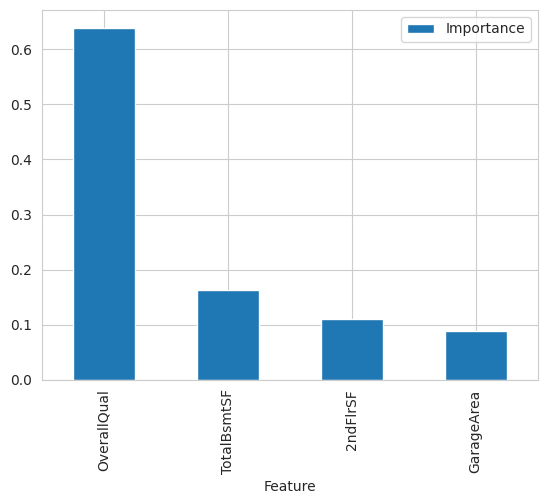

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

data_cleaning_feat_eng_steps = 10 
columns_after_data_cleaning_feat_eng = (Pipeline(best_regressor_pipeline.steps[:data_cleaning_feat_eng_steps])
                                        .transform(X_train)
                                        .columns)

best_features = columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support()].to_list()

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
          'Feature': columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support()],
          'Importance': best_regressor_pipeline['model'].feature_importances_})
  .sort_values(by='Importance', ascending=False)
  )

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{best_features}")

df_feature_importance.plot(kind='bar',x='Feature',y='Importance')
plt.show()

### Findings

* These are the 4 most important features in descending order, the model was trained on them:
- ['OverallQual', 'TotalBsmtSF', '2ndFlrSF', 'GarageArea']

## Evaluate on Train and Test Sets

In [17]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error 
import numpy as np

def regression_performance(X_train, y_train, X_test, y_test,pipeline):
	print("Model Evaluation \n")
	print("* Train Set")
	regression_evaluation(X_train,y_train,pipeline)
	print("* Test Set")
	regression_evaluation(X_test,y_test,pipeline)

def regression_evaluation(X,y,pipeline):
  prediction = pipeline.predict(X)
  print('R2 Score:', r2_score(y, prediction).round(3))  
  print('Mean Absolute Error:', mean_absolute_error(y, prediction).round(3))  
  print('Mean Squared Error:', mean_squared_error(y, prediction).round(3))  
  print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y, prediction)).round(3))
  print("\n")


def regression_evaluation_plots(X_train, y_train, X_test, y_test,pipeline, alpha_scatter=0.5):
  pred_train = pipeline.predict(X_train)
  pred_test = pipeline.predict(X_test)


  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
  sns.scatterplot(x=y_train, y=pred_train, alpha=alpha_scatter, ax=axes[0])
  sns.lineplot(x=y_train , y=y_train, color='red', ax=axes[0])
  axes[0].set_xlabel("Actual")
  axes[0].set_ylabel("Predictions")
  axes[0].set_title("Train Set")

  sns.scatterplot(x=y_test, y=pred_test, alpha=alpha_scatter, ax=axes[1])
  sns.lineplot(x=y_test, y=y_test, color='red', ax=axes[1])
  axes[1].set_xlabel("Actual")
  axes[1].set_ylabel("Predictions")
  axes[1].set_title("Test Set")
  plt.show()

Prediction objectives: The client agreed to an R2 of atleast 0.75 on the Train and Test sets:

Model Evaluation 

* Train Set
R2 Score: 0.906
Mean Absolute Error: 17783.587
Mean Squared Error: 580749250.131
Root Mean Squared Error: 24098.74


* Test Set
R2 Score: 0.832
Mean Absolute Error: 22484.658
Mean Squared Error: 1158042518.86
Root Mean Squared Error: 34030.024




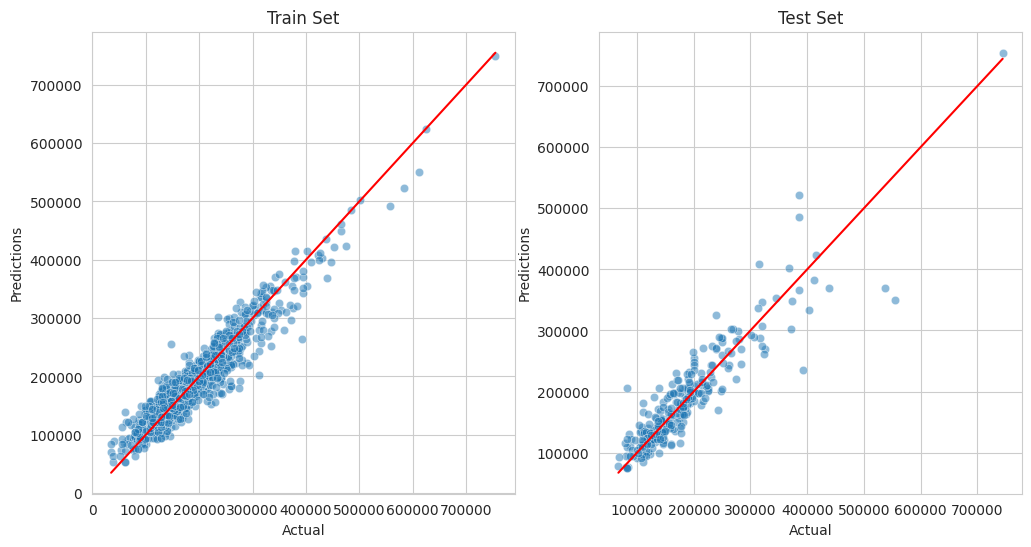

In [18]:
regression_performance(X_train, y_train, X_test, y_test,best_regressor_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test, best_regressor_pipeline)

### Findings

* Train set:
- Meet the requirements with an R2 score of 0.9
* Test set:
- Meet the requirements with an R2 score of 0.83

### Applying Regressor with Principle Component Analysis

Next we will explore any potentail values for PCA n_components:

In [19]:
pipeline = PipelineOptimization(model=LinearRegression())
pipeline_pca = Pipeline(pipeline.steps[:9])
df_pca = pipeline_pca.fit_transform(df.drop(['SalePrice'],axis=1))

print(df_pca.shape,'\n', type(df_pca))

(1460, 21) 
 <class 'pandas.core.frame.DataFrame'>


Apply PCA to the scaled data

* The 21 components explain 100.0% of the data 



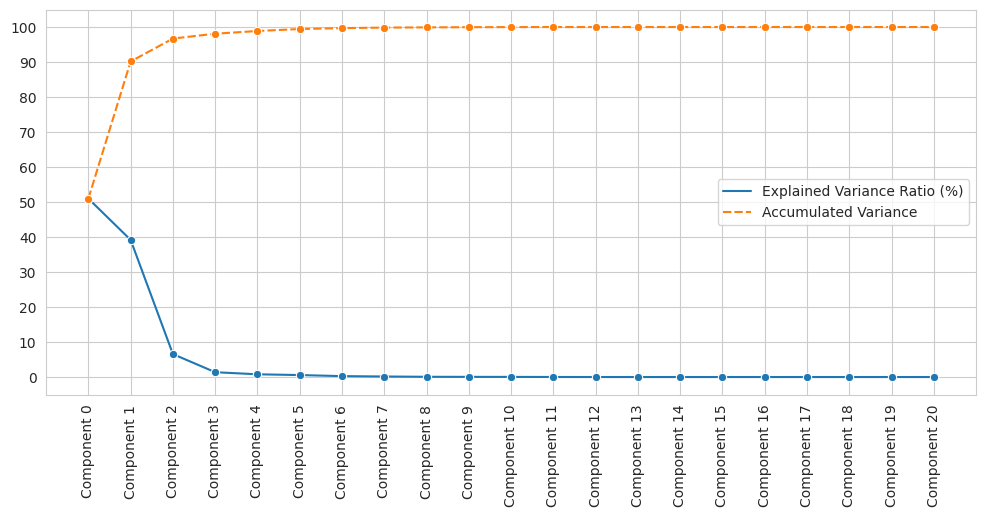

In [21]:
import numpy as np
from sklearn.decomposition import PCA

n_components = 21


def pca_components_analysis(df_pca, n_components):
    pca = PCA(n_components=n_components).fit(df_pca)
    x_PCA = pca.transform(df_pca)  # array with transformed PCA

    ComponentsList = ["Component " + str(number)
                      for number in range(n_components)]
    dfExplVarRatio = pd.DataFrame(
        data=np.round(100 * pca.explained_variance_ratio_, 3),
        index=ComponentsList,
        columns=['Explained Variance Ratio (%)'])

    dfExplVarRatio['Accumulated Variance'] = dfExplVarRatio['Explained Variance Ratio (%)'].cumsum(
    )

    PercentageOfDataExplained = dfExplVarRatio['Explained Variance Ratio (%)'].sum(
    )

    print(
        f"* The {n_components} components explain {round(PercentageOfDataExplained,2)}% of the data \n")
    plt.figure(figsize=(12, 5))
    sns.lineplot(data=dfExplVarRatio,  marker="o")
    plt.xticks(rotation=90)
    plt.yticks(np.arange(0, 110, 10))
    plt.show()


pca_components_analysis(df_pca=df_pca, n_components=n_components)

* The 4 components explain 98.08% of the data 



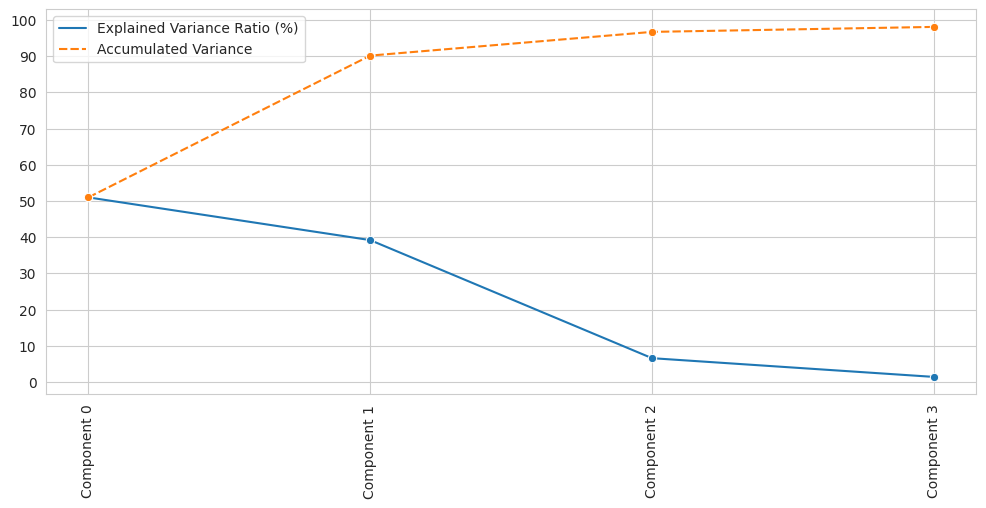

In [22]:
n_components = 4
pca_components_analysis(df_pca=df_pca,n_components=n_components)

### Findings
* We can see that even by removing some of the components, the majority of the data will stil be explained

## Rewrite ML Pipeline for Modelling using PCA

## EDIT

In [43]:
def PipelineOptimization(model):
    pipeline_base = Pipeline([
        ("ArbitraryNumberImputer", ArbitraryNumberImputer(arbitrary_number=0, variables=['2ndFlrSF'])),
        ("NumericYeoJohnsonTransform", vt.YeoJohnsonTransformer(variables=['GarageArea','TotalBsmtSF'])),
        ("scaler", StandardScaler()),
        ("model", model),
    ])

    return pipeline_base

In [44]:
print("* Train set:", X_train.shape, y_train.shape, "\n* Test set:",  X_test.shape, y_test.shape)

* Train set: (1168, 23) (1168,) 
* Test set: (292, 23) (292,)


In [45]:
models_search = {
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
}

params_search = {
    "GradientBoostingRegressor": {},
}

In [46]:
quick_search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
quick_search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pyenv_mirror/user/3.8.18/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/workspace/.pyenv_mirror/user/3.8.18/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/workspace/.pyenv_mirror/user/3.8.18/lib/python3.8/site-packages/sklearn/pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/workspace/.pyenv_mirror/user/3.8.18/lib/python3.8/site-packages/sklearn/pipeline.py", line 303, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/workspace/.pyenv_mirror/user/3.8.18/lib/python3.8/site-packages/joblib/memory.py", line 353, in __call__
    return self.func(*args, **kwargs)
  File "/workspace/.pyenv_mirror/user/3.8.18/lib/python3.8

ValueError: could not convert string to float: 'Av'